<a href="https://colab.research.google.com/github/Bryan-Az/TimeGPT-Tabula9-RDL/blob/main/Tabula9/Tabula_Mock_Data_ZeroShot_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabula 9: Mock Data Generation and Zero-shot Inference

## Installs and Imports
Tabula is not a PyPi project so it cannot be installed directly using pip and must be installed using github. Since the Tabula repo has other directories and files that are not necessary, it is possible to use sparse checkout to only checkout the necessery items.

In [1]:
%%capture
!pip install datasets # a dependency of tabula
!pip install gdown # used to download the model weights

In [2]:
!git init
!git remote add origin https://github.com/zhao-zilong/Tabula
!git config core.sparseCheckout true
!echo "/tabula/*" >> .git/info/sparse-checkout
!git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 61 (delta 30), reused 40 (delta 16), pack-reused 0 (from 0)
Unpacking objects: 100% (61/61), 54.03 KiB | 628.00 KiB/s, done.
From https://github.com/zhao-zilong/Tabula
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


## Loading the Insurance Dataset
This dataset was provided along with the Tabula repository for evaluation.

In [3]:
!echo "/Real_Datasets/*" >> .git/info/sparse-checkout
!git read-tree -mu HEAD
!git pull origin main

From https://github.com/zhao-zilong/Tabula
 * branch            main       -> FETCH_HEAD
Already up to date.


In [4]:
from tabula.tabula import Tabula
import torch
import pandas as pd

In [5]:
data = pd.read_csv("/content/Real_Datasets/Insurance_compressed.csv")

## Initializing the Tabula Model

In [6]:
categorical_columns = ["sex", "children", "sm", "region"]
model = Tabula(llm='distilgpt2', experiment_dir = "insurance_training", batch_size=32, epochs=400, categorical_columns = categorical_columns)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The tabula model architecture is not pre-trained as-is when downloaded from the github repo, but it can re-use pre-trained model weights downloaded from other models. In this example, I am using the pretrained model weights that the tabula creators created using other models on HuggingFace.

In [7]:
# adding the pretrained-model directory with the downloaded model weights
!mkdir pretrained-model
!gdown --id 1_YxelekxY5MXhgn93MYgsZEEfBYAy7h6 -O pretrained-model/model.pt

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_YxelekxY5MXhgn93MYgsZEEfBYAy7h6
From (redirected): https://drive.google.com/uc?id=1_YxelekxY5MXhgn93MYgsZEEfBYAy7h6&confirm=t&uuid=987e1a79-a57a-4f9f-ae37-d8fe14ac2649
To: /content/pretrained-model/model.pt
100% 328M/328M [00:06<00:00, 51.1MB/s]


In [8]:
model.model.load_state_dict(torch.load("pretrained-model/model.pt"), strict=False)

<ipython-input-8-ea1e96962c6c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model.load_state_dict(torch.load("pretrained-model/model.pt"), strict=False)


<All keys matched successfully>

## Fine-tuning the Tabula Model on the Insurance Dataset

The pre-trained model is now being fine-tuned on the insurance dataset.

In [9]:
model.fit(data)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.366400
1000,0.906200
1500,0.764100
2000,0.706600
2500,0.677200
3000,0.660300
3500,0.647600
4000,0.636200
4500,0.628200
5000,0.621000


In [41]:
torch.save(model.model.state_dict(), "insurance_training/insurance_tabula_model_400epochs.pt")

## Generating Mock / Synthetic Data

In [44]:
mock_data = model.sample(n_samples=1500)
mock_data.to_csv("insurance_400epoch.csv", index=False)

1578it [00:07, 206.58it/s]
/content/tabula/tabula.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.label_encoder_list[i]['column']] = pd.to_numeric(data[self.label_encoder_list[i]['column']], errors='coerce')


In [21]:
mock_data.sample(5)

,age,sex,bi,children,sm,region,charges
1117,41.0,0,35.750,1,1,0,40273.64550
1396,18.0,1,29.925,0,0,3,1708.00140
423,41.0,1,33.155,3,0,3,8538.28845
414,24.0,0,33.000,1,0,0,4462.72180
452,45.0,0,30.875,2,0,2,10325.20600


## Inferring using the Fine-Tuned Tabula Insurance Model

As Tabula uses a LLM architecture and was created for tabular mock data generation, it can use a natural language text input in the tabula_sample method to create mock data. From the plot, it is clear that the age range is centered at 20-30 as prompted. However, it still generated data outside the requested prompt.

In [33]:
%%capture
num_samples = 50
obs = []
for i in range(num_samples):
  obs.append(model.tabula_sample('Age is 20-30'))
output = pd.concat(obs)

<Axes: ylabel='Frequency'>

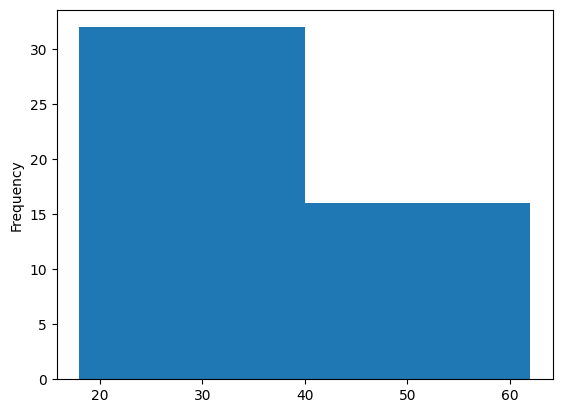

In [40]:
output['age'].dropna().astype(int).plot(kind='hist', bins=2)

## Saving the Model to Huggingface

In [17]:
from huggingface_hub import notebook_login, HfApi

In [15]:
notebook_login()

In [42]:
api = HfApi()
api.create_repo(repo_id="Alexis-Az/insurance-tabula-model-400epoch", repo_type="model", private=False)

RepoUrl('https://huggingface.co/Alexis-Az/insurance-tabula-model-400epoch', endpoint='https://huggingface.co', repo_type='model', repo_id='Alexis-Az/insurance-tabula-model-400epoch')

In [43]:
api.upload_file(
    path_or_fileobj="insurance_training/insurance_tabula_model_3epoch.pt",
    path_in_repo="insurance_tabula_model_3epoch.pt",
    repo_id="Alexis-Az/insurance-tabula-model-400epoch",  # Replace with your repo ID
    repo_type="model",
)

insurance_tabula_model_3epoch.pt:   0%|          | 0.00/328M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Alexis-Az/insurance-tabula-model-400epoch/commit/c6793fcede2c83d0660c11f6a7d649902428fbe9', commit_message='Upload insurance_tabula_model_3epoch.pt with huggingface_hub', commit_description='', oid='c6793fcede2c83d0660c11f6a7d649902428fbe9', pr_url=None, pr_revision=None, pr_num=None)